# Estimating Personal Spending Budget

---


## **Formula**
The moving average smooths short-term fluctuations and highlights long-term trends or cycles.
The moving average (MA) formula with a rolling window size \( n \) given by:

\begin{equation}
\text{MA}_n(t) = \frac{1}{n} \sum_{i=0}^{n-1} X_{t-i}
\end{equation}

\begin{align}
{MA}_n(t)
  \qquad\text{is moving average at \( t \) with window size \( n \)} \\
X_{t-i}
  \qquad\text{represents the value when \( t-i \)} \\
n
  \qquad\text{is the total period in the moving average window.}
\end{align}

## **Implementation**

For a 2-month rolling window size, the moving average for the month \( t \) defined as:

\begin{equation}
\text{MA}_2(t) = \frac{1}{2} \left( X_t + X_{t-1} \right)
\end{equation}

This formula is applied to each month in the dataset to smooth monthly expenditures and predict the budget for the following month.


# **Import Library**

In [89]:
import csv
import pickle
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from dataclasses import dataclass
from absl import logging
import copy
import math
%matplotlib inline
logging.set_verbosity(logging.ERROR)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Layer

In [90]:
# Load data csv
df = pd.read_csv('/content/Personal Transactions - Gebung.csv')

In [91]:
# Load the head data
df.head(10)

,Date,Category,Description,Amount,Type
0,6/1/2024,Food,Sapi,"15,000.00",Expense
1,6/1/2024,Utilities,Galon,"19,000.00",Expense
2,6/1/2024,Mobile Phone,Pulsa,"20,000.00",Expense
3,6/2/2024,Groceries,Bahan makanan,"56,000.00",Expense
4,6/2/2024,Rent,Bayar kost,"1,000,000.00",Expense
5,6/2/2024,Entertainment,IQiyl,"2,000.00",Expense
6,6/3/2024,Food,Ketoprak,"9,000.00",Expense
7,6/4/2024,Shopping,Sepatu,"35,000.00",Expense
8,6/4/2024,Other,Gaji Freelance,"100,000.00",Income
9,6/5/2024,Transportation,Top up Gopay,"50,000.00",Expense


In [92]:
# Load the data information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858 entries, 0 to 1857
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         1858 non-null   object
 1   Category     1858 non-null   object
 2   Description  1858 non-null   object
 3   Amount       1858 non-null   object
 4   Type         1858 non-null   object
dtypes: object(5)
memory usage: 72.7+ KB
None


In [93]:
# Load basic statistics
print(df.describe())

            Date Category Description     Amount     Type
count       1858     1858        1858       1858     1858
unique       810       10          80       1520        2
top     9/2/2024     Food         Bus  19,000.00  Expense
freq           8      592         204         26     1800


In [94]:
# Check the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858 entries, 0 to 1857
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         1858 non-null   object
 1   Category     1858 non-null   object
 2   Description  1858 non-null   object
 3   Amount       1858 non-null   object
 4   Type         1858 non-null   object
dtypes: object(5)
memory usage: 72.7+ KB
None


In [95]:
df['Amount'] = df['Amount'].str.replace(',', '')
df['Amount'] = df['Amount'].astype(float)

In [96]:
# Check the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1858 entries, 0 to 1857
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1858 non-null   object 
 1   Category     1858 non-null   object 
 2   Description  1858 non-null   object 
 3   Amount       1858 non-null   float64
 4   Type         1858 non-null   object 
dtypes: float64(1), object(4)
memory usage: 72.7+ KB
None


In [97]:
# Check for any missing value
df.isna().sum()

Date           0
Category       0
Description    0
Amount         0
Type           0
dtype: int64

In [98]:
# Change the Date row into datetime
df['Date'] = pd.to_datetime(df['Date'])
print(df["Date"].dtypes)

datetime64[ns]


In [99]:
df['Amount'].max()

4750000.0

In [100]:
df['Amount'].min()

500.0

                                Date        Amount
count                           1858  1.858000e+03
mean   2025-04-11 04:32:48.568353024  8.134605e+04
min              2024-06-01 00:00:00  5.000000e+02
25%              2024-12-09 06:00:00  2.112650e+04
50%              2025-03-11 00:00:00  6.163550e+04
75%              2025-06-18 00:00:00  1.009878e+05
max              2026-08-19 00:00:00  4.750000e+06
std                              NaN  1.894902e+05
Date           0
Category       0
Description    0
Amount         0
Type           0
dtype: int64


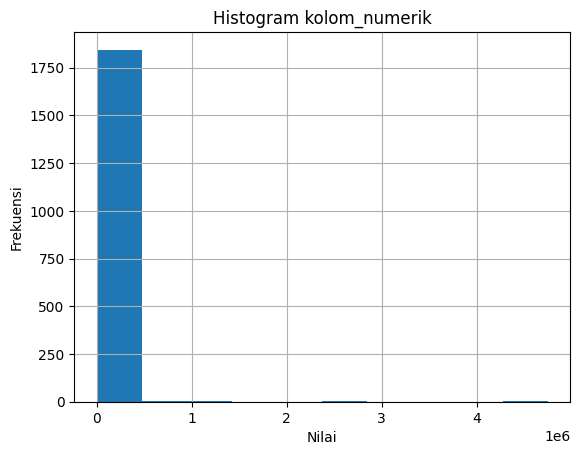

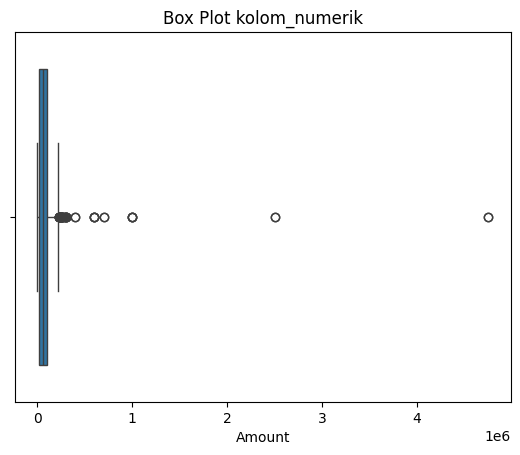

In [101]:
# Descriptive Statistics
print(df.describe())

# Missing Values
print(df.isnull().sum())

# Histogram
df['Amount'].hist()
plt.title('Histogram kolom_numerik')
plt.xlabel('Nilai')
plt.ylabel('Frekuensi')
plt.show()

# Box Plot
sns.boxplot(x=df['Amount'])
plt.title('Box Plot kolom_numerik')
plt.show()

# **Sum all the data by each month**

In [102]:
df['Month'] = df['Date'].dt.to_period('M')

In [103]:
result = df.groupby('Month')['Amount'].sum().reset_index()

In [104]:
result

,Month,Amount
0,2024-06,5264714.0
1,2024-07,8410999.0
2,2024-08,3203499.0
3,2024-09,7765956.0
4,2024-10,4225275.0
5,2024-11,6545435.0
6,2024-12,7420712.0
7,2025-01,12156877.0
8,2025-02,20211520.0
9,2025-03,12078638.0


In [105]:
# Saving the actual value
y_actual = result['Amount'].values

## **To TF**

In [106]:
# Input preparation
window_size = 2
data = result['Amount'].values.astype(np.float32).reshape(-1, 1)
data = data[np.newaxis, :, :]

In [107]:
# Define MovingAverage Layer and Model
class MovingAverage(tf.keras.layers.Layer):
    def __init__(self, window_size, **kwargs):
        super(MovingAverage, self).__init__(**kwargs)
        self.window_size = window_size

    def call(self, inputs):
        cumsum = tf.cumsum(inputs, axis=1)
        cumsum = tf.concat([tf.zeros_like(cumsum[:, :1]), cumsum], axis=1)
        moving_avg = (cumsum[:, self.window_size:] - cumsum[:, :-self.window_size]) / self.window_size
        return moving_avg[:, -1:]

def create_moving_average_model(window_size):
    inputs = tf.keras.Input(shape=(None, 1))
    outputs = MovingAverage(window_size)(inputs)
    model = tf.keras.Model(inputs, outputs)
    return model

# Create and compile the model
model = create_moving_average_model(window_size)
model.compile(optimizer='adam', loss='mse')

## **Prediction**

In [108]:
# Predict the next month expense
y_pred = model.predict(data)

# Data last actual value (Comparison)
actual_next_month_expense = y_actual[-1]

# Predicted value
predicted_next_month_expense = y_pred[0][0]

1/1 [==============================] - 0s 53ms/step


### **JSON**

In [109]:
# Save the prediction into a new row in DataFrame
predicted_values = np.append([np.nan] * (window_size - 1), y_pred.flatten())

# Ensure the length of predicted_values matches the length of the result dataframe
predicted_values = np.append(predicted_values, [np.nan] * (len(result) - len(predicted_values)))

# RUn orediction for every month using moving average
for i in range(window_size, len(result)):
    current_data = result['Amount'].values[:i].astype(np.float32).reshape(1, -1, 1)
    y_pred = model.predict(current_data)
    predicted_values[i] = y_pred[0][0]

# Add the predicted values to the result dataframe
result['Moving_Avg'] = predicted_values

# Convert to JSON Format
data = []
for i in range(len(result)):
    data.append({
        "month": result['Month'].iloc[i].strftime('%Y-%m'),
        "actual": float(result['Amount'].iloc[i]),
        "predicted": float(result['Moving_Avg'].iloc[i]) if not np.isnan(result['Moving_Avg'].iloc[i]) else None
    })

json_data = {
    "data": data
}

json_output = json.dumps(json_data, indent=4)
print(json_output)

1/1 [==============================] - 0s 16ms/step


<ipython-input-109-7905196acbe2>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_values[i] = y_pred[0][0]


1/1 [==============================] - 0s 17ms/step
{
    "data": [
        {
            "month": "2024-06",
            "actual": 5264714.0,
            "predicted": null
        },
        {
            "month": "2024-07",
            "actual": 8410999.0,
            "predicted": 1826600.0
        },
        {
            "month": "2024-08",
            "actual": 3203499.0,
            "predicted": 6837856.5
        },
        {
            "month": "2024-09",
            "actual": 7765956.0,
            "predicted": 5807249.0
        },
        {
            "month": "2024-10",
            "actual": 4225275.0,
            "predicted": 5484727.5
        },
        {
            "month": "2024-11",
            "actual": 6545435.0,
            "predicted": 5995616.0
        },
        {
            "month": "2024-12",
            "actual": 7420712.0,
            "predicted": 5385356.0
        },
        {
            "month": "2025-01",
            "actual": 12156877.0,
            "p

### **Convert to TFLite**

In [110]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('moving_average_model.tflite', 'wb') as f:
    f.write(tflite_model)

### ** Mean Absolute Error(MAE)**

In [111]:
# Hitung Mean Absolute Error (MAE)
mae = mean_absolute_error([actual_next_month_expense], [predicted_next_month_expense])
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 523132.0


### ** Mean Absolute Percentage Error (MAPE)**

In [112]:
# Filter out NaN values from predictions for valid calculation
valid_idx = ~np.isnan(result['Moving_Avg'])
y_actual_valid = y_actual[valid_idx]
y_pred_valid = result['Moving_Avg'][valid_idx]

# Count Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_actual_valid - y_pred_valid) / y_actual_valid)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Percentage Error (MAPE): 94.94%


### ** Root Mean Squared Error (RMSE)**

In [113]:
# Count Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_actual_valid, y_pred_valid))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 4029207.0897806045


### **Coefficient of Determination (R-squared)**

In [114]:
# Count Coefficient of Determination (R-squared)
r2 = r2_score(y_actual_valid, y_pred_valid)
print(f"Coefficient of Determination (R-squared): {r2}")

Coefficient of Determination (R-squared): 0.27142975065567854


In [115]:
result = df.groupby('Month')['Amount'].sum().reset_index()
df['Month'] = df['Date'].dt.to_period('M')
result['Month'] = result['Month'].dt.to_timestamp()

# **Prediction**

In [116]:
window_size = 2
result['Moving_Avg'] = result['Amount'].rolling(window=window_size).mean()

def predict_next_month(expenses, window_size):
    return expenses.rolling(window=window_size).mean().iloc[-1]

next_month_expense_prediction = predict_next_month(result['Amount'], window_size)

next_month_expense_prediction

1826596.0

# **Plot**

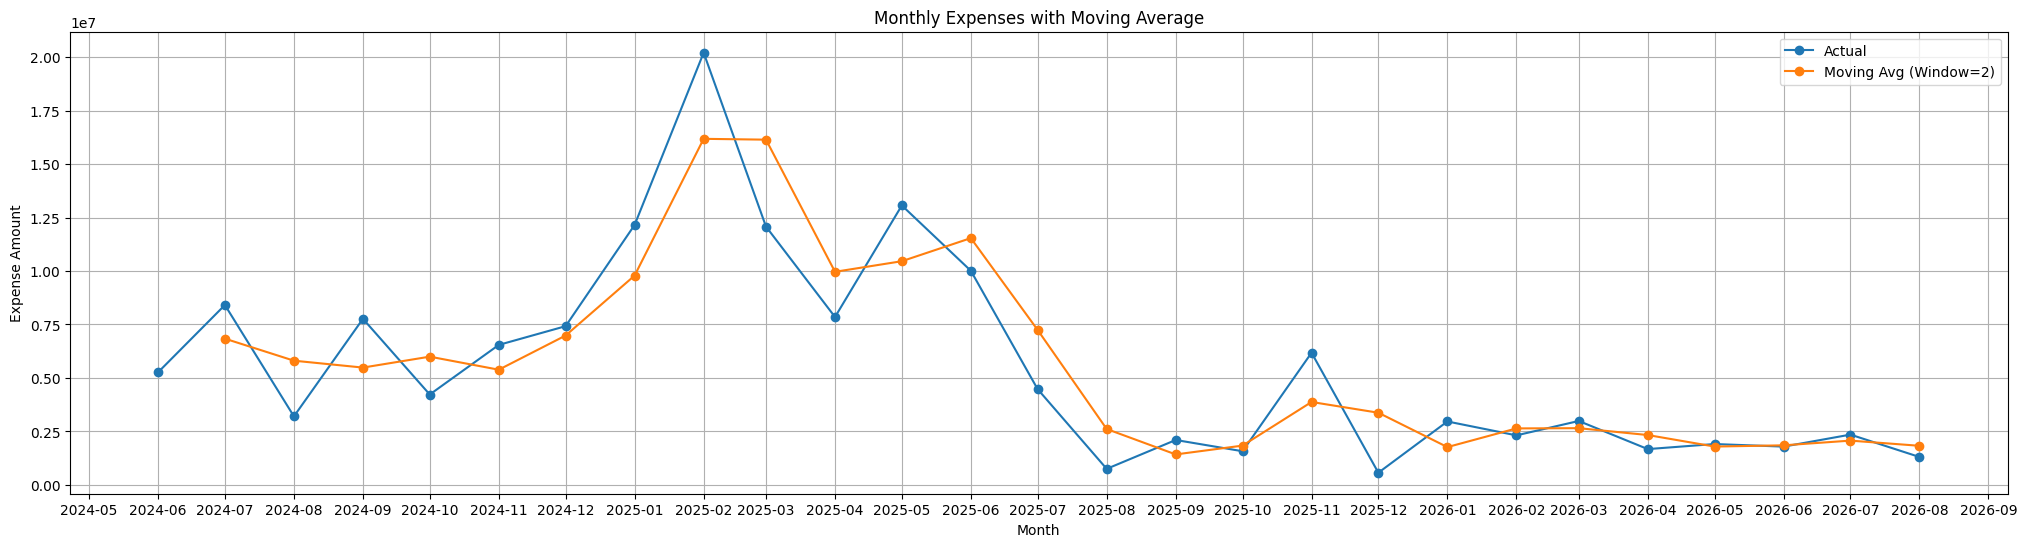

Prediksi pengeluaran bulan depan: 1826596.0


In [117]:
plt.figure(figsize=(25, 6))
plt.plot(result['Month'], result['Amount'], label='Actual', marker='o')
plt.plot(result['Month'], result['Moving_Avg'], label='Moving Avg (Window=2)', marker='o')
plt.title('Monthly Expenses with Moving Average')
plt.xlabel('Month')
plt.ylabel('Expense Amount')
plt.legend()
plt.grid(True)

#tambahan
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.show()

print("Prediksi pengeluaran bulan depan:", next_month_expense_prediction)